# Week 6: Practical ML

**Online Resources:**
- [Machine Learning Course at Edx](https://www.edx.org/course/machine-learning)
- [Applied Machine Learning Course at Columbia](https://www.cs.columbia.edu/~amueller/comsw4995s19/schedule/)
- [Machine Learning Course by Andrew Ng](https://www.coursera.org/learn/machine-learning)
- [Google ML Crash Course](https://developers.google.com/machine-learning/crash-course/ml-intro)
- [Categorical Encoders](https://contrib.scikit-learn.org/category_encoders/)
- [Categorical Encoders Kaggle](https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark/notebook)

In [1]:
from typing import Any, Dict

import numpy as np
import pandas as pd
import math

import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

In [6]:
dataset = sklearn.datasets.fetch_california_housing()

X_all = dataset['data'].astype('float32')
y_all = dataset['target'].astype('float32')

X = {}
y = {}
X['train'], X['test'], y['train'], y['test'] = sklearn.model_selection.train_test_split(
    X_all, y_all, train_size=0.8
)

X_orig=X.copy()

In [7]:
print(dataset['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

(array([1811., 5957., 4877., 2403.,  839.,  338.,  137.,   69.,   32.,
          49.]),
 array([ 0.49990001,  1.94992006,  3.39994001,  4.84995985,  6.29998016,
         7.75      ,  9.20001984, 10.65003967, 12.10006046, 13.5500803 ,
        15.00010014]),
 <BarContainer object of 10 artists>)

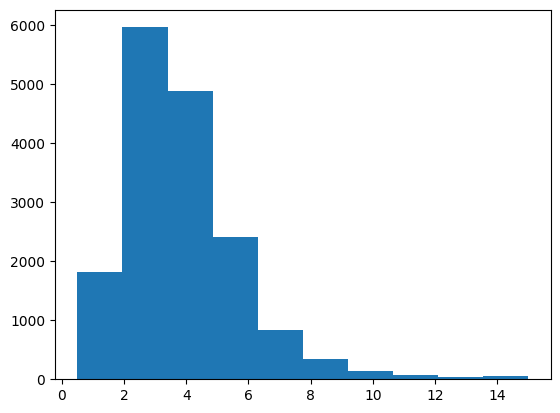

In [8]:
plt.hist(X['train'][:,0])

(array([1625., 1644., 1588., 1620., 1702., 1632., 1657., 1631., 1665.,
        1748.]),
 array([-1.        , -0.80000001, -0.60000002, -0.40000001, -0.2       ,
         0.        ,  0.2       ,  0.40000001,  0.60000002,  0.80000001,
         1.        ]),
 <BarContainer object of 10 artists>)

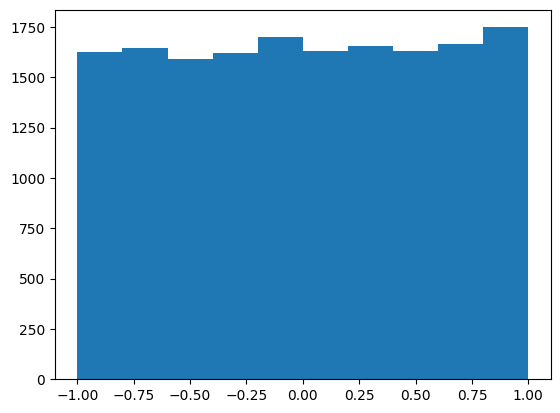

In [10]:
# !!! CRUCIAL THIS MUST BE ON TRAINING ONLY !!!
# preprocess = sklearn.preprocessing.StandardScaler().fit(X_orig['train'])
preprocess = sklearn.preprocessing.QuantileTransformer().fit(X_orig['train'])
# preprocess = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1),clip=True).fit(X_orig['train'])

X = {
    k: (2*preprocess.transform(v)-1)
    for k, v in X_orig.items()
}
# X = {
#     k: preprocess.transform(v)
#     for k, v in X_orig.items()
# }

plt.hist(X['train'][:,0])

In [11]:
X['train'][:,0].mean()

0.009648142

In [12]:
y = {k: v for k, v in y.items()}

# !!! CRUCIAL THIS MUST BE ON TRAINING ONLY !!!
y_mean = y['train'].mean().item()
y_std = y['train'].std().item()
y = {k: (v - y_mean) / y_std for k, v in y.items()}


# Decision Trees
The *decision tree* model performs classification and regression by segment the predictor space into a number of decision regions with simple rules. This method is simple and useful for interpretation, and it is the building block of a very popular method called *random forests*.

*Reading: Elements of Statistical Learning, Section 9.2*

**Big thank you to Professor Liang Zhao much of the material on tree-based methods**

## Model Intuition
People may ask the following questions in order to find out if a person is fit or unfit:
1. Are you older than 30?
2. If yes, do you eat pizza more than once a week?
3. If no, do you exercise more than 2 hours a week?
Based on the responde, we can form a tree diagram to express the prediction:
<img src="https://lh4.googleusercontent.com/v9UQUwaQTAXVH90b-Ugyw2_61_uErfYvTBtG-RNRNB_eHUFq9AmAN_2IOdfOETnbXImnQVN-wPC7_YzDgf7urCeyhyx5UZmuSwV8BVsV8VnHxl1KtgpuxDifJ4pLE23ooYXLlnc" width="600">

## An Example: Will John Plays Tennis?
<img src="https://github.com/ch00226855/CMP464-788-Spring2019/raw/master/Data/DT_1.png">

- It is hard to see how existing data can help us making decisions on new data
- Split cases according to the outlook

<img src="https://github.com/ch00226855/CMP464-788-Spring2019/raw/master/Data/DT_3.png">

- John played tennis in overcast weather
- If it is sunny or rainy, John's decision depends on other factors as well.
- Split this group further by humidity

<img src="https://github.com/ch00226855/CMP464-788-Spring2019/raw/master/Data/DT_4.png">

- If it was sunny with high humidity, John never played tennis
- If it was sunny with normal humidity, John always played tennis
- Split rainy group by wind strength

<img src="https://github.com/ch00226855/CMP464-788-Spring2019/raw/master/Data/DT_5.png">

- If it was rainy with strong wind, John never player tennis
- If it was rainy with weak wind, John always played tennis
- **What can we say about the new data?**

## Decision Tree Algorithm
- Choose the best feature for splitting the data into subsets
- If a subset is pure: stop
- If a subset is impure: repeat

**Question: How should we determine which feature to choose?** How to measure the impurity of a subset?

<img src="https://github.com/ch00226855/CMP464-788-Spring2019/raw/master/Data/DT_6.png">

- The measurement should clearly distinguish the pure case (100% for one outcome) and the completely uncertain case (50% - 50%)
- The measurement should be symmetric: (4 yes / 0 no) is just as good as (0 yes / 4 no)

##Feature Selection: Use Gini Impurity as measurement

For each subset:
- Let $p_{yes}$ be the probability of a randomly chosen case in the subset to be a yes.
- Let $p_{no}$ be the probability of a randomly chosen case in the subset to be a no
- The **Gini impurity** of this subset is calculated as

$G = 1 - p_{yes}^2 - p_{no}^2$

**Discussion**:
- What is the minimal value for Gini impurity?
Ans: 0.
- What subsets have minimal Gini impurity?
Ans: if a set only contains one type of instances, then its Gini impurity will be 0.
- What is the maximal value for Gini impurity?
Ans: In binary case, the maximal value is 1 - 1/4 - 1/4 = 1/2. In n-class case, the maximal value is 1 - (1/n)^2 * n = (n-1)/n.
- What kind of sets have maximal Gini impurity?
Ans: A set has maximal Gini impurity if and only if all probabilities are equal.
- Does (4 yes / 0 no) has the same Gini impurity as (0 yes / 4 no)?
Ans: Yes, the class labels do not matter.

For example, in the "Sunny" subset there are 2 yes and 3 no, so a randomly chosen case is yes with probability $2 / 5 = 0.4$, and it is no with probability $3 / 5 = 0.6$. Its Gini impurity is

$G_{sunny} = 1 - 0.4^2 - 0.6^2 = 0.48$.

- Gini impurity for "Overcast":$G_{overcast}=1 - 1^2 = 0$
- Gini impurity for "Rain":$G_{rain}=1 - 0.6^2 - 0.4^2 = 0.48$

The overall cost of using "Outlook" to split the data is a weighted sum of all Gini impurities:

$J(outlook) = \frac{m_{sunny}}{m}G_{sunny} + \frac{m_{overcast}}{m}G_{overcast} + \frac{m_{rain}}{m}G_{rain}=\frac{5}{14}\times 0.48 + \frac{4}{14}\times 0 + \frac{5}{14}\times 0.48 = 0.3429$

Here $m_{subset}$ is the number of instances in the subset, m is the total number of instances.

Next, compute the cost of using "Wind" to split the data:
- Gini impurity for "Weak": $G_{weak} = 1 - 0.75^2 - 0.25^2 = 0.375$
- Gini impurity for "Strong": $G_{strong} = 1 - 0.5^2 - 0.5^2 = 0.5$
- $J(wind) = \frac{8}{14}G_{weak} + \frac{6}{14}G_{strong}= 0.4286$

**Conclusion**: Outlook splits the dataset better.

##Feature Selection: Use entropy as measurement
For each subset, its **entropy** is calculates as

$H = -p_{yes}\log(p_{yes}) - p_{no}\log(p_{no})$.

Note that $log(p)$ is undefined if $p=0$. In this case we let $p\log(p)=0$.

**Discussion**:
- What is the minimal value for entropy?
Ans: 0
- What subsets have minimal entropy?
Ans: Pure sets.
- What is the maximal value for entropy?

- What subsets have maximal entropy?
Ans: when instances are equally distributed among all classes.
- Does (4 yes / 0 no) have the same entropy as (0 yes / 4 no)?
Ans: Yes.

- $H_{sunny} = -0.4\times\log(0.4) - 0.6\times\log(0.6) = 0.2923$
- $H_{overcast} = -1\times\log(1) - 0\times\log(0) = 0$
- $H_{rain} = -0.6\times\log(0.6) - 0.4\times\log(0.4)=0.2923$.
- The overall cost of "Outlook" is a weighted sum of all entropies:

$J(outlook) = \frac{m_{sunny}}{m}H_{sunny} + \frac{m_{overcast}}{m}H_{overcast} + \frac{m_{rain}}{m}H_{rain}=\frac{5}{14}\times 0.2923 + \frac{4}{14}\times 0 + \frac{5}{14}\times 0.2923 = 0.2088$

## Building A Decision Tree: Classification of Iris flowers

Recall that this is a dataset of 150 records under 5 attributes - petal length, petal width, sepal length, sepal width, and class. The goal of this classification task is to predict the class of each flower based on the other four attributes.

<img src="https://miro.medium.com/max/2550/1*7bnLKsChXq94QjtAiRn40w.png">

In [13]:
# Train a decision tree on petal length and width
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
from sklearn.datasets import load_iris
iris = load_iris()
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [15]:
data = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
data['target'] = iris['target']
print(iris['target_names'])
data.head()

['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


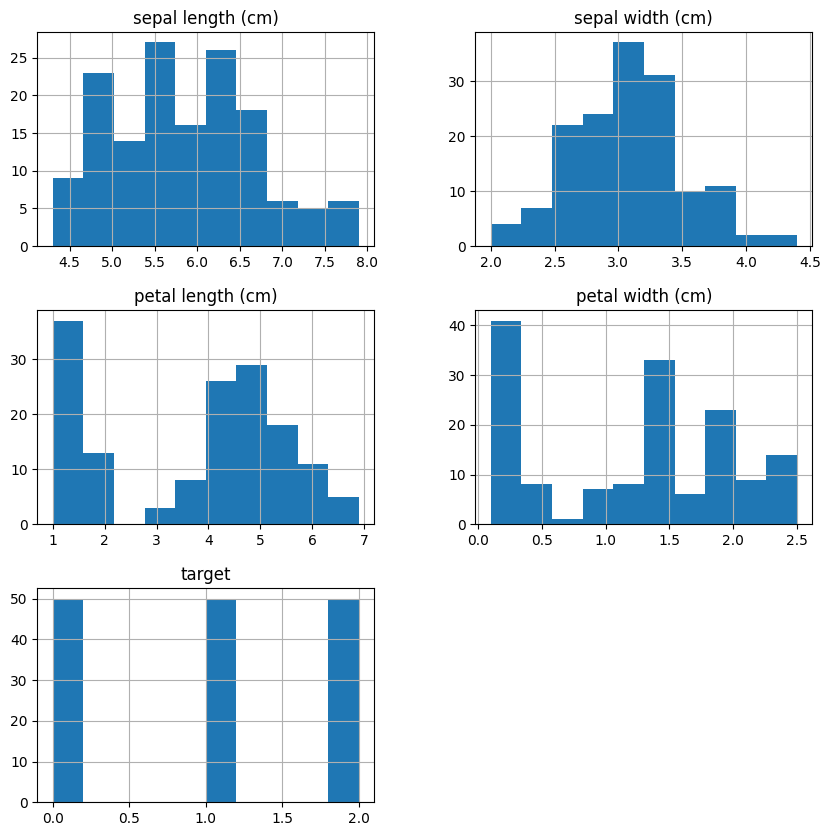

In [16]:
data.hist(figsize=(10, 10))
plt.show()

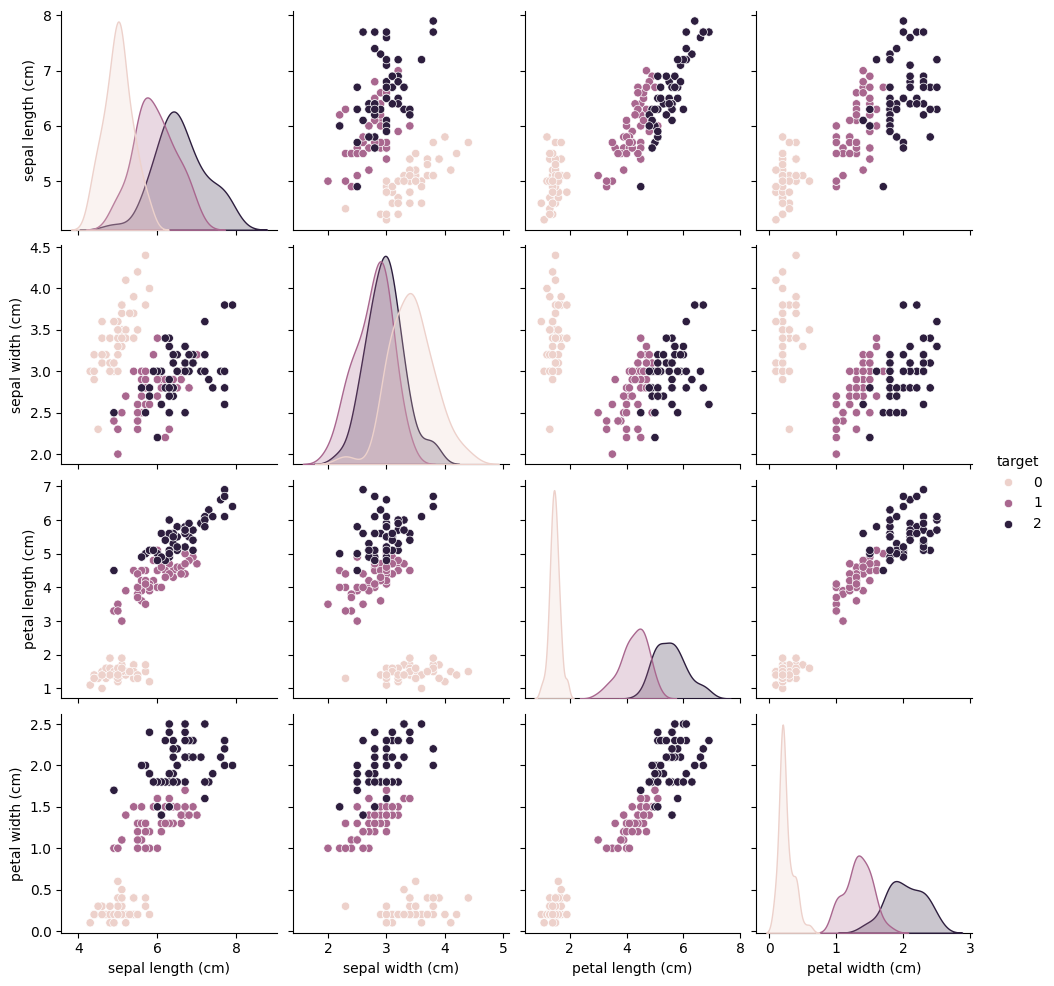

In [17]:
import seaborn as sns
sns.pairplot(data, hue="target")

In [18]:
# Build a decision tree
from sklearn.tree import DecisionTreeClassifier

X = data.iloc[:, :4]
y = data['target']
tree_clf = DecisionTreeClassifier(max_depth=2,
                                  random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

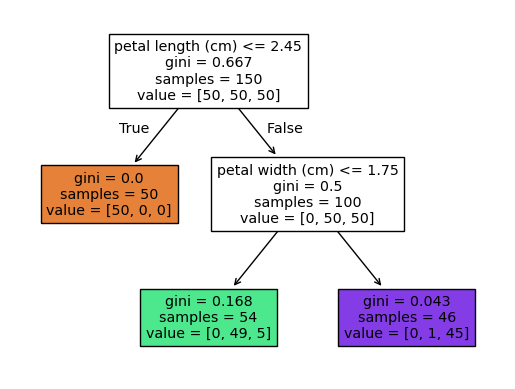

In [19]:
# Visualize the decision tree
from sklearn.tree import plot_tree
plot_tree(tree_clf, feature_names=X.columns, filled=True)
plt.show()

Let's build a model using petal length and petal width, so that we can visualize its decision boundary

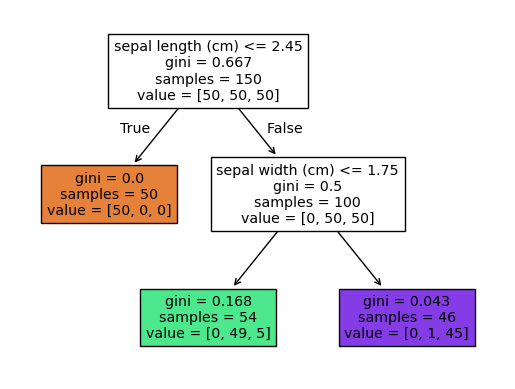

In [20]:
X2 = data.iloc[:, 2:4]
tree_clf2 = DecisionTreeClassifier(max_depth=2,
                                  random_state=42)
tree_clf2.fit(X2, y)
plot_tree(tree_clf2, feature_names=X.columns, filled=True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


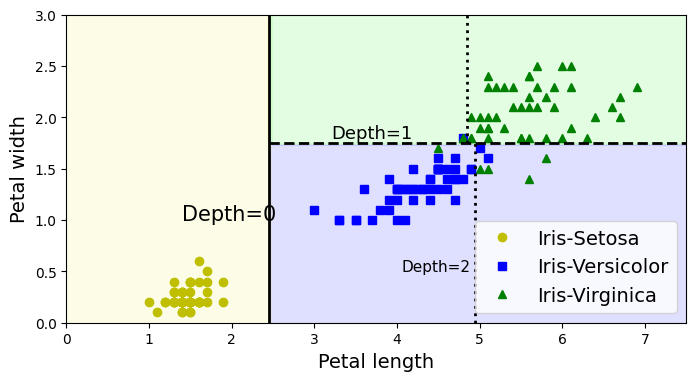

In [21]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf,
                           X,
                           y,
                           axes=[0, 7.5, 0, 3]):

    # Create a grid of points
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)

    # Use numpy.ravel() to flatten x1 and x2
    X_new = np.c_[x1.ravel(), x2.ravel()]

    # Use classifier to obtain predictions on X_new
    y_pred = clf.predict(X_new).reshape(x1.shape)

    # Pick three colors representing classes
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

    # Use contourf() to draw classification areas
    plt.contourf(x1,
                 x2,
                 y_pred,
                 alpha=0.3,
                 cmap=custom_cmap)

    # plot training instances
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
    plt.axis(axes)

    # Display label and legends
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
    plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf2, X2.values, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "Depth=2", fontsize=11)

plt.show()

### Discussion
Decision trees make very few assumptions about the training data. If left unconstrained, the tree structure will adapt itself to overfitting the training data. Thus it is necessary to use hyperparameters to restrict the shape of Decision tree.
- max_depth: the maximal depth of the decision tree
- min_sample_split: the minimum number of samples a node must have before it can split
- min_samples_leaf: the minimum number of samples a leaf node must have
- min_weight_fraction_leaf: the minimum fraction of samples a leaf node must have
- max_leaf_nodes: the maximum number of leaf nodes
- max_features: the maximum number of features evaluated at each node

Increasing min_* or reducing max_* will reduce overfitting.
<img src="https://github.com/ch00226855/CMP464-788-Spring2019/raw/master/Data/DT_8.png">

## Regression Trees
Decision trees are also capable of performing regression tasks. The main differences are:
- Instead of predicting a class in each node, it predicts a value
- Gini impurity and entropy are no longer viable choices for cost function. A common choice is MSE (mean-squared-error) or MAE (mean-absolute-error) function.

In [22]:
import numpy as np

In [23]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

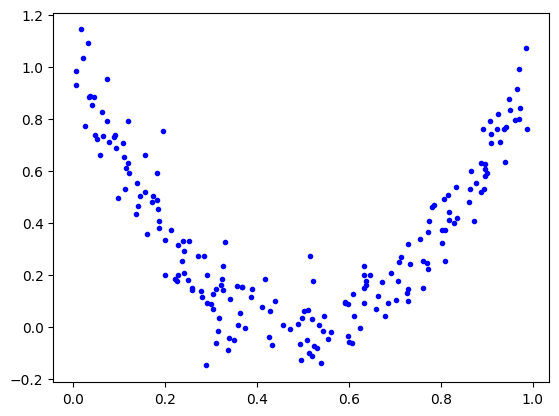

In [24]:
import matplotlib.pyplot as plt
plt.plot(X, y, 'b.')

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=3, random_state=42)

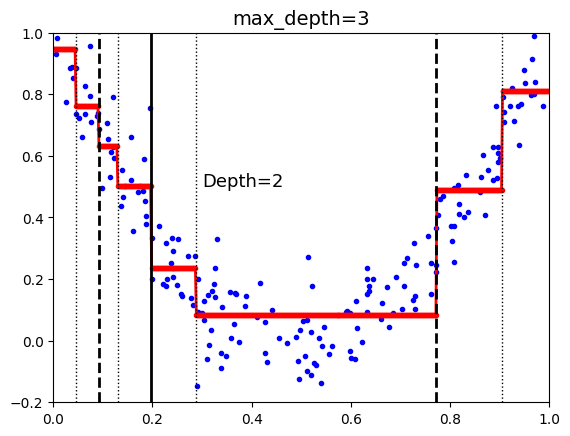

In [26]:
def plot_regression_predictions(tree_reg,
                                X,
                                y,
                                axes=[0, 1, -0.2, 1]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2)

plot_regression_predictions(tree_reg, X, y)

# Draw decision boundaries
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)
plt.show()

## Pitfalls of Decision Trees
- Overfitting
- Extrapolation
- Instability
- Categorical Variables
- Missing value imputation

## Random Forest: A Ensemble of Decision Trees
- Train multiple decision trees separatedly.
- For each split, only consider a random subset of all available features.
- Let all trees vote to get the final prediction.

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=2,
    n_jobs=-1
)
rf_clf.fit(X2, data['target'])

RandomForestClassifier(max_depth=2, n_estimators=500, n_jobs=-1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


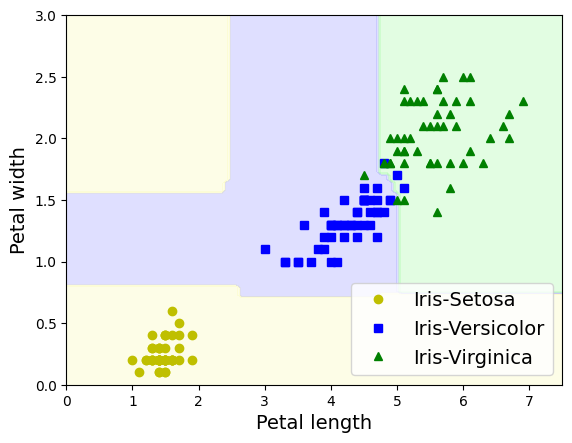

In [28]:
plot_decision_boundary(rf_clf, X2.values, data['target'])

## Ensemble Learning

The goal of ensemble learning is to combine the predictions of several base estimators in order to improve generalizability and robustness

>**Wisdom of the crowd:** the collective opinion of a group of individuals is often better than that of a single expert.

### Popular Ensemble methods
- Build several estimators *independently* and then average their predictions. On average, the combined estimator is usually better than any of the single base estimator.

**Examples:** Bagging, random forests.
- Build several estimators *sequentially* with each new one trying to reduce the bias of the previous estimators.

**Examples:** AdaBoost, Gradient Boost, XGBoost
- Build a model to aggregate the predictions of several other models. The second-level model learns to highlight where each base estimator performs best and discredit where it performs poorly.

**Examples** Stacking, *neural networks*

## Basic Ensemble Techniques
- Voting
- Averaging

Let's use the moon dataset to illustrate the power of ensemble methods.

In [29]:
# Create a moon-shape dataset
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.3)

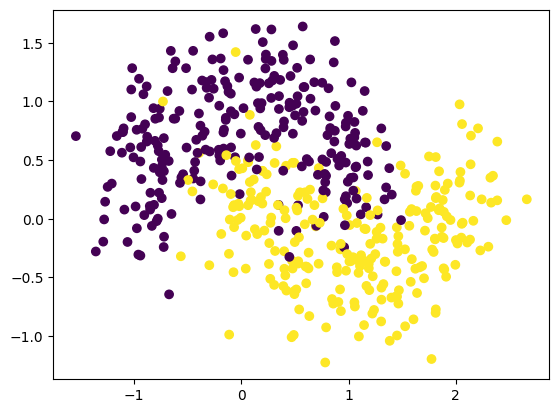

In [30]:
# Plot the dataset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:500,1], c=y)
plt.show()

### Model 1: A single decision tree

In [31]:
# Split the dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [32]:
# Apply a Decision Tree model to build a classifier
from sklearn.tree import DecisionTreeClassifier
tree_clas = DecisionTreeClassifier(max_depth = 5)
tree_clas.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

In [33]:
# Calculate the accuracy score on test set
from sklearn.metrics import accuracy_score
y_test_pred = tree_clas.predict(X_test) # predict y value for test set
score = accuracy_score(y_test, y_test_pred)
print(score)

0.95


In [34]:
# Visualize the decision boundary
def plot_decision_boundary(model, X, y):
    padding=0.1
    res=0.01

    x_min,x_max=X[:,0].min(), X[:,0].max()
    y_min, y_max=X[:,1].min(), X[:,1].max()

    x_range=x_max-x_min
    y_range=y_max-y_min

    xx,yy= np.meshgrid(np.arange(x_min,x_max,res),np.arange(y_min,y_max,res))


    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx,yy,Z, cmap=plt.cm.Accent)

    plt.scatter(X[:,0], X[:,1],s=35,c=y,cmap=plt.cm.cool)

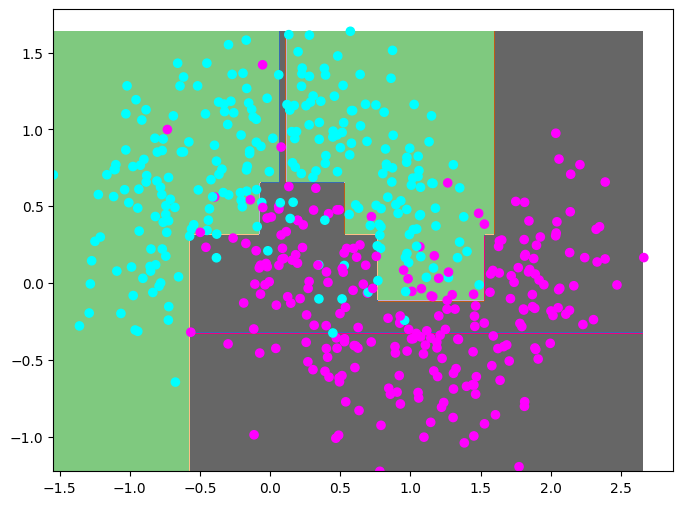

In [35]:
plot_decision_boundary(tree_clas,X,y)

### Model 2: Combining logistic regression, kNN, linear SVM, and two decision trees

Let's train three classifiers and let them vote for the final decision

In [36]:
# Import classifiers
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

lr_clf = LogisticRegression(solver='lbfgs')
knn_clf = KNeighborsClassifier(n_neighbors=1)
svm_clf = LinearSVC()
dt_clf1 = DecisionTreeClassifier(max_depth=2)
dt_clf2 = DecisionTreeClassifier(max_depth=3)

voting_clf = VotingClassifier(
    estimators=[('lr', lr_clf),
                ('knn', knn_clf),
                ('svm', svm_clf),
                ('dt1', dt_clf1),
                ('dt2', dt_clf2)],
    voting='hard' # 'soft': compare sum of probabilities
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('knn', KNeighborsClassifier(n_neighbors=1)),
                             ('svm', LinearSVC()),
                             ('dt1', DecisionTreeClassifier(max_depth=2)),
                             ('dt2', DecisionTreeClassifier(max_depth=3))])

In [37]:
# Calculate accuracy score for each model
for clf in (lr_clf, knn_clf, svm_clf, dt_clf1, dt_clf2, voting_clf):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    print(clf.__class__.__name__,
          accuracy_score(y_test, y_test_pred))

LogisticRegression 0.91
KNeighborsClassifier 0.89
LinearSVC 0.91
DecisionTreeClassifier 0.93
DecisionTreeClassifier 0.93
VotingClassifier 0.93


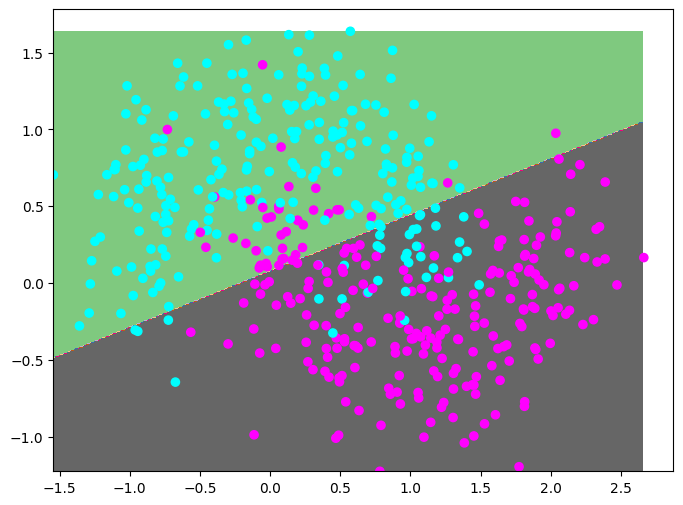

In [38]:
plot_decision_boundary(lr_clf, X,y)

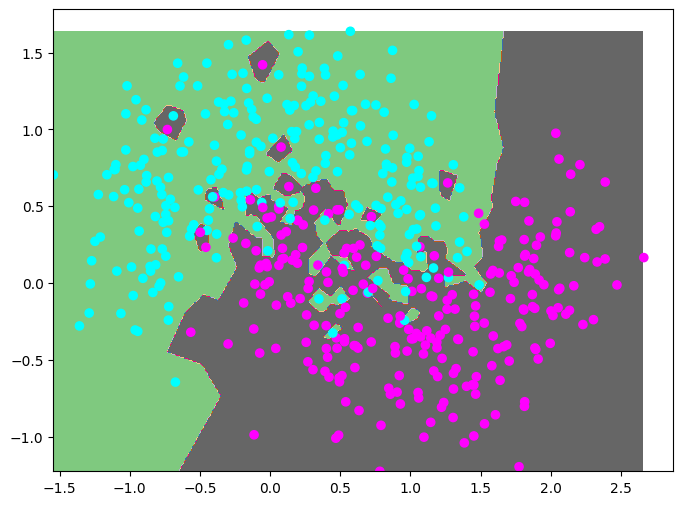

In [39]:
plot_decision_boundary(knn_clf, X,y)

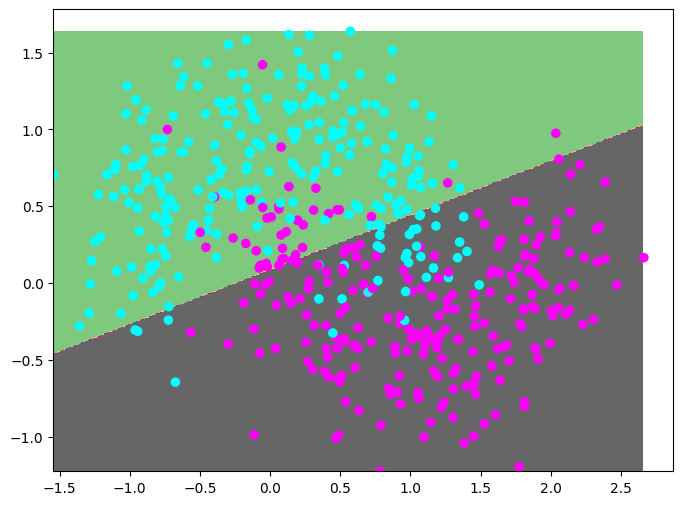

In [40]:
plot_decision_boundary(svm_clf, X,y)

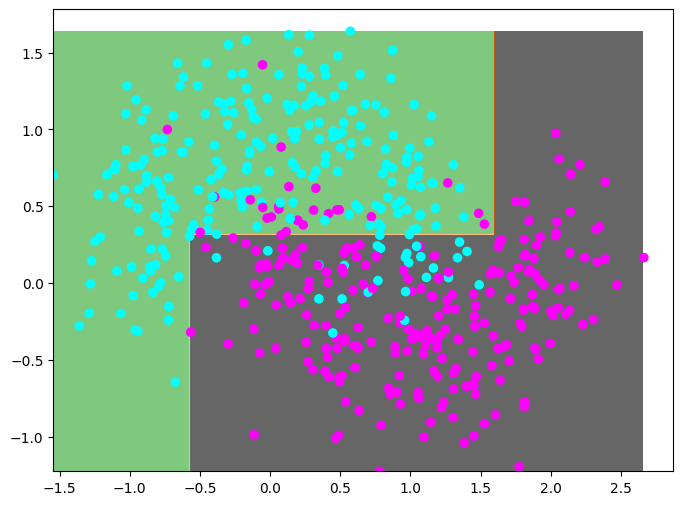

In [41]:
plot_decision_boundary(dt_clf1, X,y)

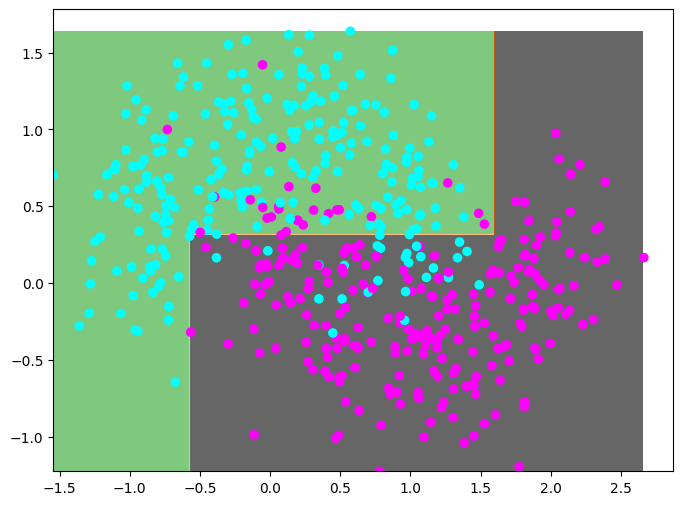

In [42]:
plot_decision_boundary(dt_clf2, X,y)

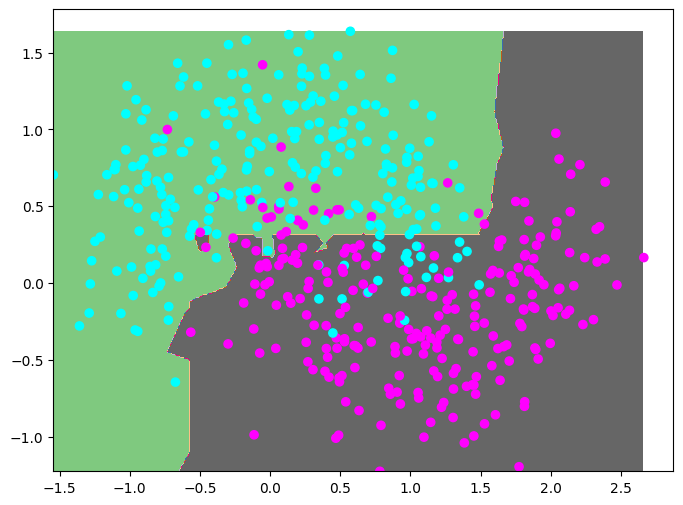

In [43]:
plot_decision_boundary(voting_clf, X,y)

## Bagging and Pasting
Another approach is to use the same training algorithm for every classifier, but to train them on different random subsets of the training set.
- When sampling is performed *with* replacement, this method is called **bagging**.
- When sampling is performed *without* replacement, it is called **pasting**.

Bagging and pasting allow training instances to be sampled several times across multiple classifiers, but only bagging allows training instances to be sampled several times for the same classifier.

Once all base models are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all models. The aggregation is typically the **majority vote** for classification, or the **average** for regression.

In [44]:
# Build an ensemble of 500 decision trees
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=5),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                  max_samples=100, n_estimators=500, n_jobs=-1)

In [45]:
# Compute accuracy score
y_test_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_test_pred))

0.93


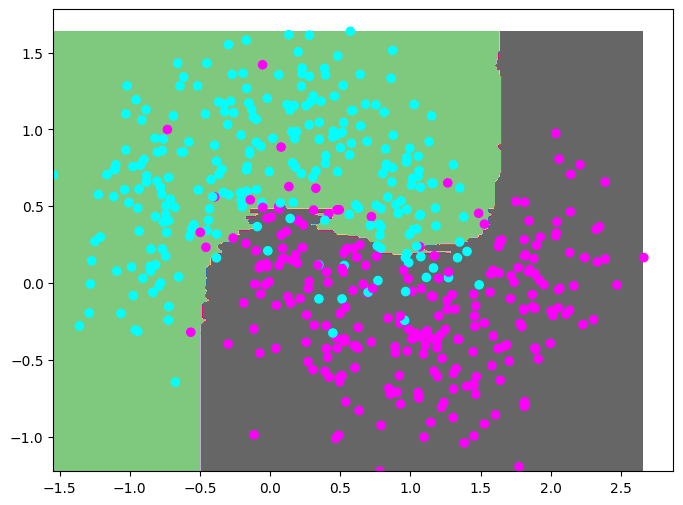

In [46]:
plot_decision_boundary(bag_clf, X,y)

## Boosting

Boosting refers to Ensemble methods that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

## AdaBoost
AdaBoost, short for *Adaptive Boosting*, is a boosting methods where each predictor is trained with more attention to the training instances that its predecessor underfitted.

### AdaBoost algorithm
- Train a base classifier (such as a Decision Tree)
- Calculate the accuracy of the base classifier and find all misclassified training instances
- Increase the weights of the misclassified training instances
- Train a second base classifier
- Repeat Step 2-4

The **weight** of a training instance refers to the factor of its error term in the cost function.

Once all predictors are trained, the ensemble makes predictions by taking votes from each base predictor. Unlike bagging/pasting methods, predictors have different weights depending on their overall accuracy on the weighted training set.

## Gradient Boosting
Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration, this method tries to fit the new predictor to the *residual errors* made by the previous predictor

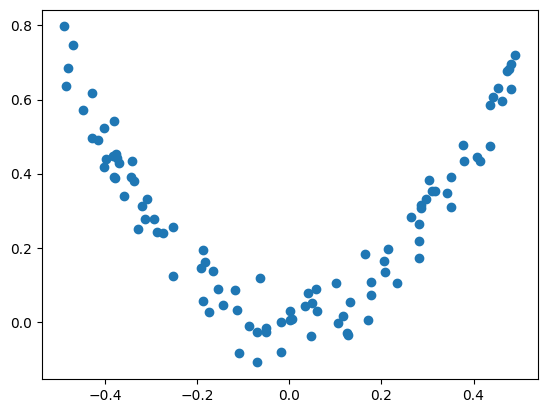

In [47]:
# Create dataset for regression
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)
plt.scatter(X, y)
plt.show()

In [49]:
# Build a base Decision Tree regressor
from sklearn.tree import DecisionTreeRegressor
dt1 = DecisionTreeRegressor(max_depth=2)
dt1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

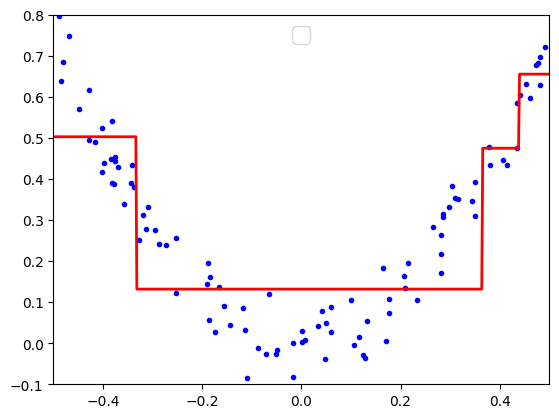

In [50]:
# Visualize the regression line

def plot_predictions(regressors,
                     X,
                     y,
                     axes,
                     label=None,
                     style='r-',
                     data_label=None,
                     data_style='b.'):
    # Create a input array
    x1 = np.linspace(axes[0], axes[1], 500)

    # Obtain model prediction
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))\
                 for regressor in regressors)

    # Plot data points
    plt.plot(X[:, 0], y, data_style, label=data_label)

    # Plot regression line
    plt.plot(x1, y_pred, style, linewidth=2, label=label)

    plt.legend(loc='upper center', fontsize=16)
    plt.axis(axes)

plot_predictions([dt1], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8])

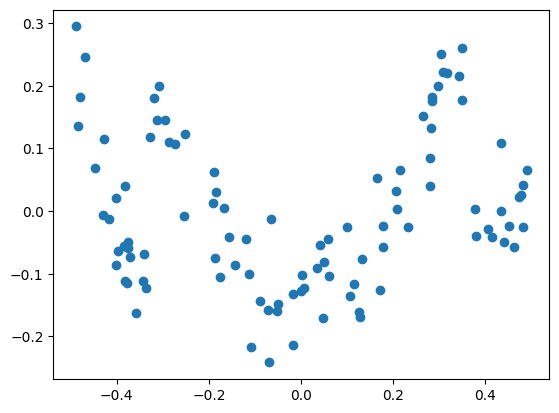

In [52]:
# Calculate the residual errors made by this regressor
y2 = y - dt1.predict(X)
plt.scatter(X, y2)
plt.show()

In [53]:
# Build another Decision Tree to fit error y2
dt2 = DecisionTreeRegressor(max_depth=2)
dt2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

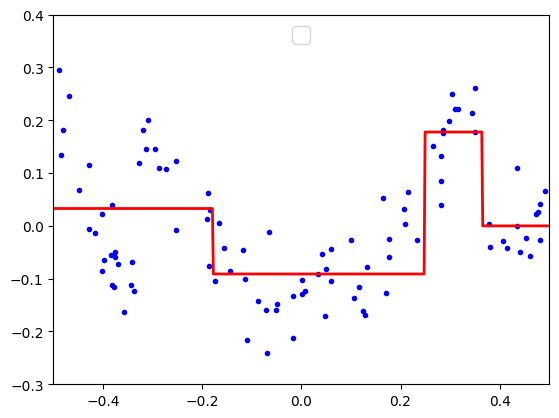

In [54]:
# Visualize the second regressor
plot_predictions([dt2], X, y2,
                 axes=[-0.5, 0.5, -0.3, 0.4])

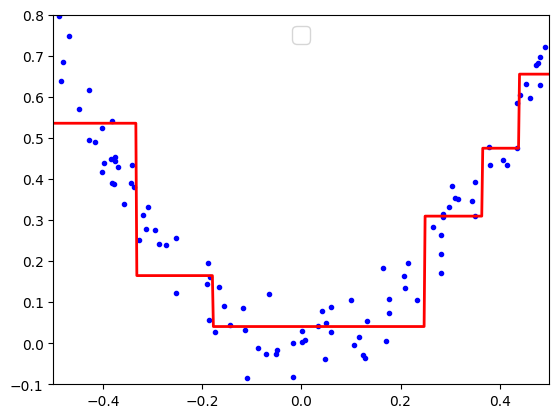

In [55]:
# Visualize the ensemble
plot_predictions([dt1, dt2], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8])

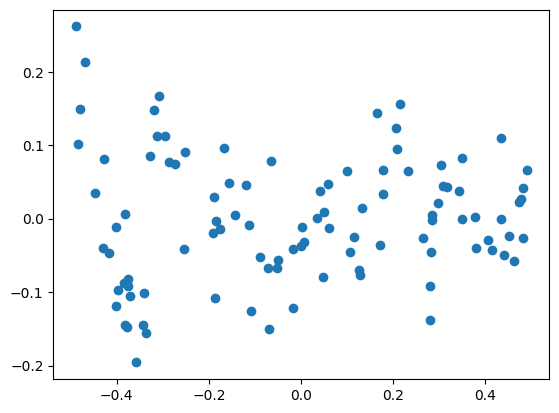

In [56]:
# Calculate the residual errors made by this regressor
y3 = y2 - dt2.predict(X)
plt.scatter(X, y3)
plt.show()

In [57]:
# Build the third Decision Tree to fit error y3
dt3 = DecisionTreeRegressor(max_depth=2)
dt3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

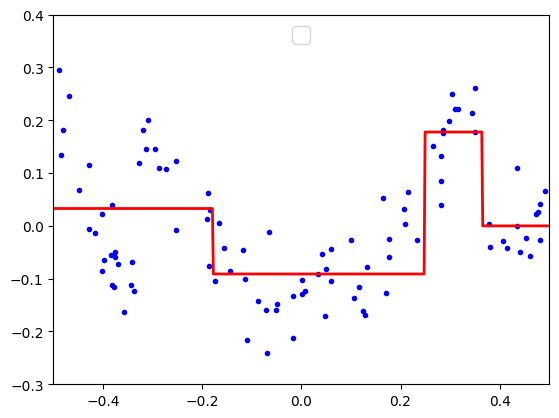

In [58]:
# Visualize the second regressor
plot_predictions([dt2], X, y2,
                 axes=[-0.5, 0.5, -0.3, 0.4])

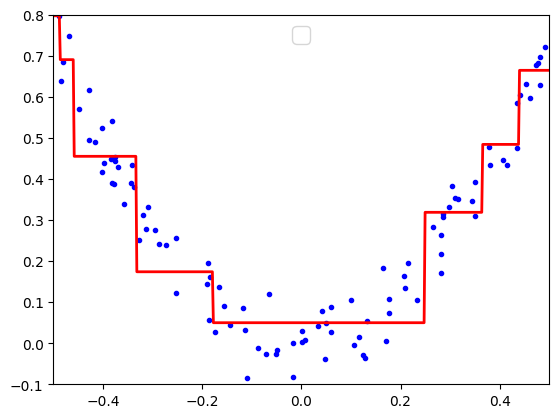

In [59]:
# Visualize the ensemble
plot_predictions([dt1, dt2, dt3], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8])

### Gradient Boosting using sklearn

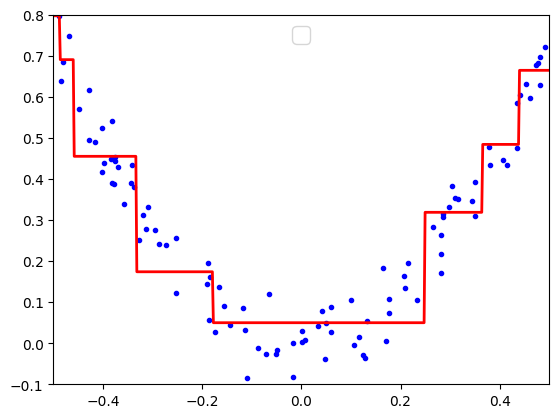

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(max_depth=2,
                                  n_estimators=3,
                                  learning_rate=1.0)
model.fit(X, y)
plot_predictions([model], X, y, axes=[-0.5, 0.5, -0.1, 0.8])

**Parameters:**
- learning_rate shrinks the contribution of each tree, reducing model overfitting
- subsample: limiting the fraction of samples to be used for fitting each individual tree.

## Stacking

Stacking is based on a simple idea: instead of using trivial function (such as hard voting), why don't we train a model to aggregate the predictions of all base predictors? A common approach is to split the training set into two subsets. The first subset is used to train each base predictors, and the second subset is used to train the *meta learner*. Another approach is to split the data into folds and refit the base predictors multiple times allowing you to create out of sample predictions for every point and feed those into the meta learner / downstream model.

### Stacking algorithm
- Split the training set into $S_1$ and $S_2$.
- Train each base predictor by fitting it to $S_i$.
- Record the prediction of each base predictor on $S_{j \neq i}$.
- Use these predictions as input, train the meta learner.
- After training meta learner you may chose to re-train the base predictor on (S1+S2) to use on future data

**Note: this is 2-fold stacking, but any k fold stacking can be used (typically 5)**

**Example**

tf-idf->regularaized logisitc regression (elasticnet)-> (out of sample predictions)-> Gradient Boosted Tree

In order to make all data (out of sample) we split out data into S1 and S2 and use other split for Gradiant Boosted Tree

How to use this in a final model?